In [1]:
import sys
sys.version

import exoplanet
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
from astropy import units as u
from astropy.constants import M_earth, M_sun
from simulate_data_radec2 import *
from model_data_radec2 import *

import matplotlib 
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)



WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


exoplanet.__version__ = '0.5.1'


/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate_data_radec2.py:372: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate_data_radec2.py:447: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate_data_radec2.py:472: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


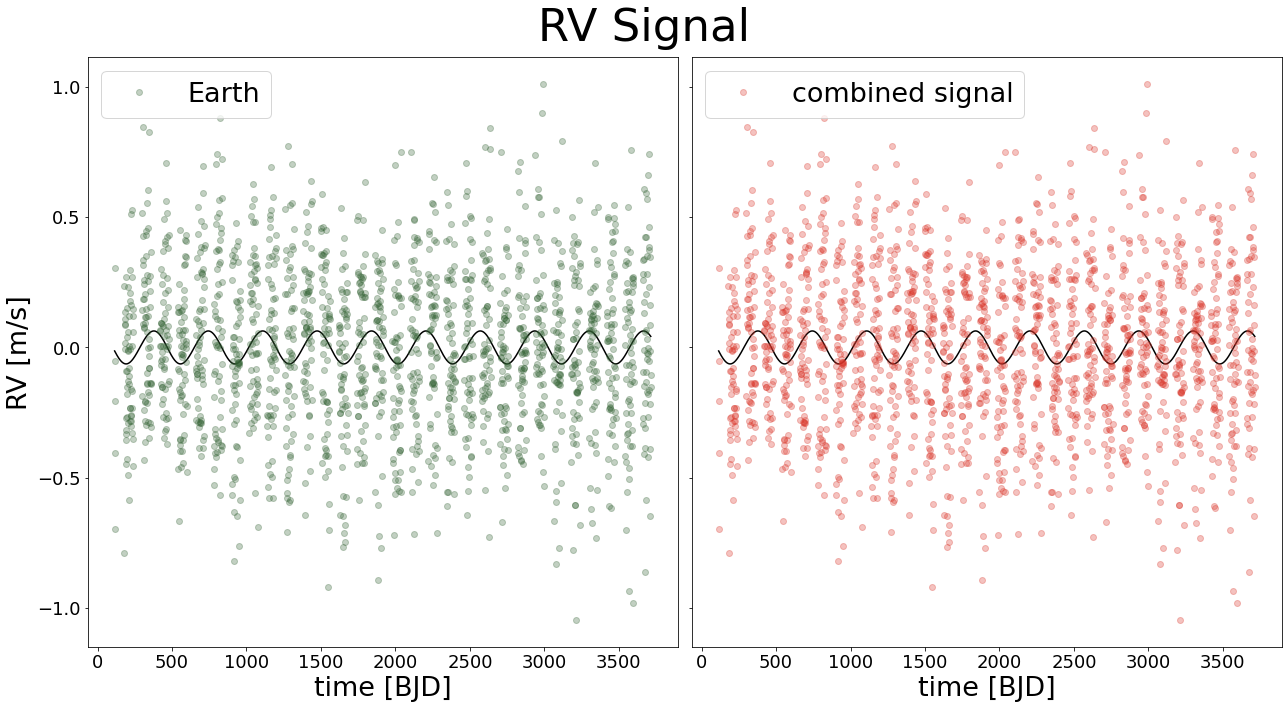

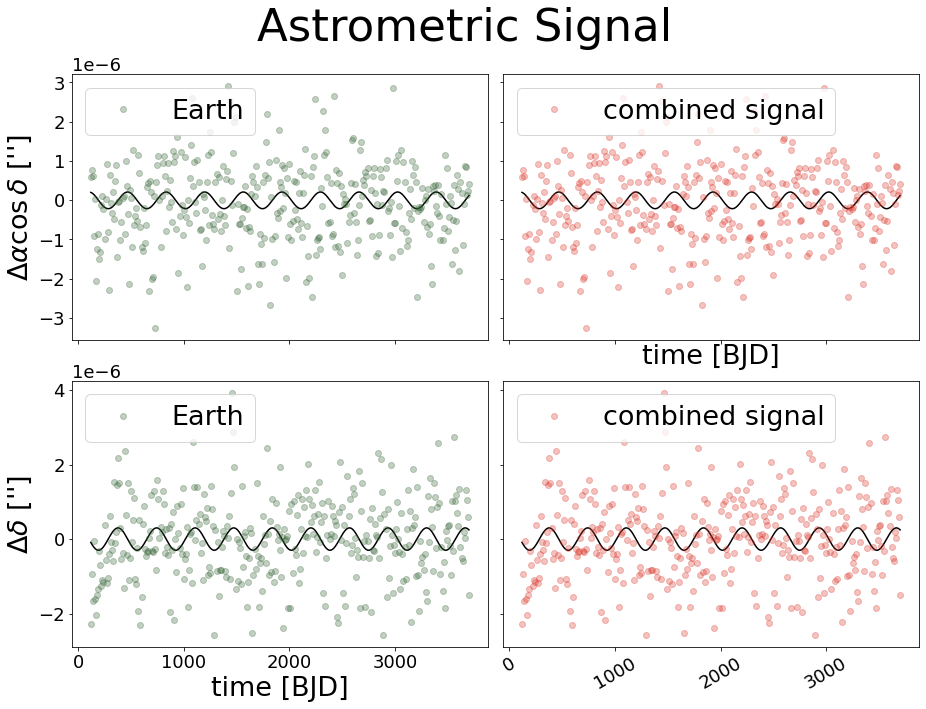

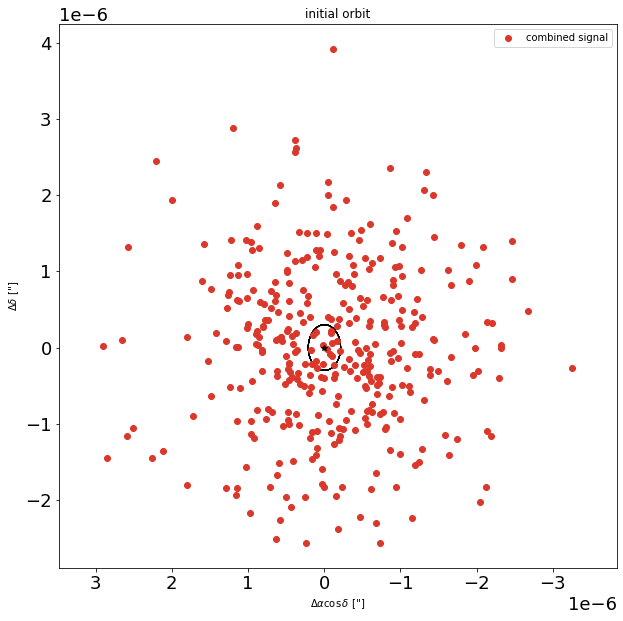

In [7]:
T_subtract = 2454000
# orbital parameters from https://www.princeton.edu/~willman/planetary_systems/Sol/
# BJD determined by converting values above using https://ssd.jpl.nasa.gov/tc.cgi#top

P_earth = 365.256
e_earth = 0.0167
Tper_earth= 2454115.5208333 - T_subtract
omega_earth = np.radians(102.9)
Omega_earth = np.radians(0.0)
inclination_earth = np.radians(45.0)
m_earth = 1*3.00273e-6 #units m_sun



P_jup = 4327.631
e_jup = 0.0484
Tper_jup = 2455633.7215278 - T_subtract
omega_jup = np.radians(274.3) - 2*np.pi
Omega_jup = np.radians(100.4)
inclination_jup = np.radians(1.31) + inclination_earth
m_jup = 317.83*3.00273e-6 #units m_sun


m_sun = 333030 #earth masses


times_observed_astrometry = []
t_0 = int(Tper_earth)
for ii in range(t_0, t_0+1800):
    if ii % 10 == 0:
        times_observed_astrometry.append(ii)

t_1 =  times_observed_astrometry[-1]+0
for ii in range(t_1, t_1+1800):
    if ii % 10 == 0:
        times_observed_astrometry.append(ii)      
        
times_observed_rv = []
t_0 = int(Tper_earth)
add_data = True
for ii in range(t_0, t_0+3600):
    
    if ii % 60 == 0:
        if add_data:
            add_data = False
        else:
            add_data = True
       
    if add_data:
        times_observed_rv.append(ii)
        

orbit_params_earth = [P_earth, e_earth, Tper_earth, omega_earth, Omega_earth, inclination_earth, m_earth]
orbit_params_jup = [P_jup, e_jup, Tper_jup, omega_jup, Omega_jup, inclination_jup, m_jup]

n_planets = 1
orbit_params = [orbit_params_earth, orbit_params_jup]


sigma_rv = 0.3

sigma_ra = 1e-6
sigma_dec = 1e-6
parallax = 0.1



times, rv_results, theta_results, rho_results = simulate_and_plot(
    n_planets, 
    sigma_rv, 
    sigma_ra,
    sigma_dec,
    parallax,
    orbit_params,
    ['#366537', '#db372b', '#00257c'],
    ['Earth', 'Jupiter'],
    times_observed_rv = times_observed_rv,
    times_observed_astrometry = times_observed_astrometry
    )


[[times_rv, times_observed_rv, times_astrometry, times_observed_astrometry],
[rv_orbit, rv_orbit_sum, rv_sim, rv_sim_sum],
[ra_orbit, ra_orbit_sum, ra_sim, ra_sim_sum],
[dec_orbit, dec_orbit_sum, dec_sim, dec_sim_sum]]  = times, rv_results, theta_results, rho_results



In [3]:
x_rv = np.array(times_observed_rv)
y_rv = rv_sim_sum
y_rv_err = np.full(np.shape(y_rv), sigma_rv)

x_astrometry = np.array(times_observed_astrometry)
ra_data = ra_sim_sum
ra_err = np.full(np.shape(ra_data), sigma_ra)
dec_data = dec_sim_sum
dec_err = np.full(np.shape(dec_data), sigma_dec)


# make a fine grid that spans the observation window for plotting purposes
t_astrometry = np.linspace(x_astrometry.min() - 5, x_astrometry.max() + 5, 1000)
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)

# for predicted orbits
t_fine = np.linspace(x_astrometry.min() - 500, x_astrometry.max() + 500, num=1000)





finding RV model solutions


optimizing logp for variables: [logK, ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -3186489.4310296844 -> 1101.3147844144225
optimizing logp for variables: [logK, ecs, tperi, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: 1101.3147844144225 -> 3410.4282596221888
optimizing logp for variables: [logs, ecs, logK, tperi, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: 3410.4282596221888 -> 3410.431137605188


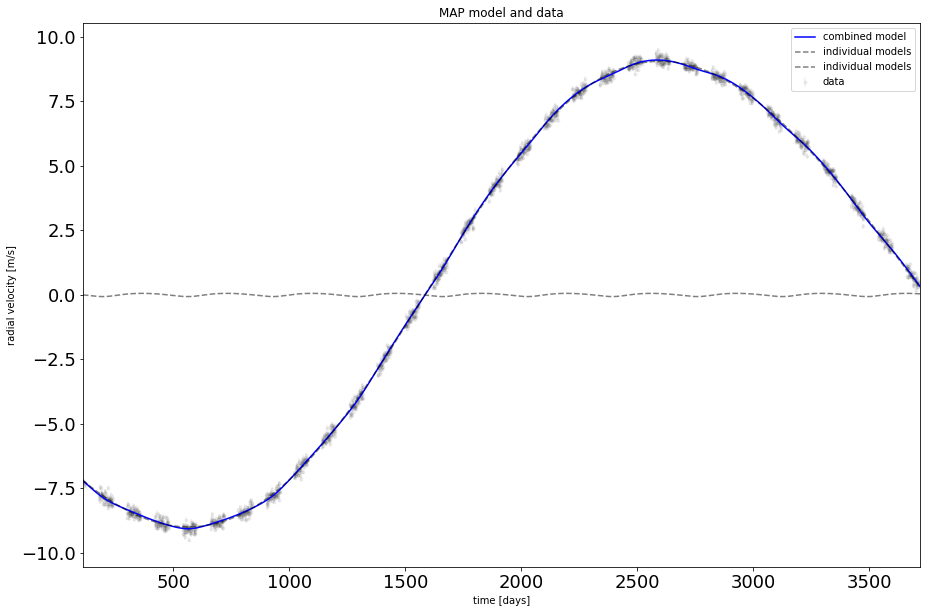

In [4]:

periods_guess = [360, 4330]
Ks_guess = xo.estimate_semi_amplitude(periods_guess, x_rv, y_rv, y_rv_err)


print("finding RV model solutions")
rv_map_soln = model_rv(periods_guess, Ks_guess, x_rv, y_rv, y_rv_err)

fig, ax = plt.subplots(1, figsize = [15,10])

ax.errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha = 0.05, label='data', zorder=1)
ax.plot(t_rv, rv_map_soln["rv_model_pred"], "b", label="combined model", zorder=2)
ax.plot(t_rv, rv_map_soln["vrad_pred"], "--k", alpha=0.5, label="individual models")


ax.legend(fontsize=10)
ax.set_xlim(t_rv.min(), t_rv.max())
ax.set_xlabel("time [days]")
ax.set_ylabel("radial velocity [m/s]")
ax.set_title("MAP model and data")

plt.show()



In [5]:
print("finding joint model solutions")
parallax = 0.1 # arcsec
model, map_soln = model_both(rv_map_soln, x_rv, y_rv, y_rv_err, x_astrometry, 
                             ra_data, ra_err, dec_data, dec_err, parallax)



finding joint model solutions
[ 366.19034253 4324.4046865 ]
[0.0623451  9.02203823]
[ 213.81731005 1623.8491651 ]
[0.14581755 0.04706992]
[-2.71811669 -1.51086091]


optimizing logp for variables: [phase, sqrtm_sini_1, sqrtm_cosi_1, sqrtm_sini_2, sqrtm_cosi_2]


message: Desired error not necessarily achieved due to precision loss.
logp: -447821687151.4528 -> -21769683628.581703
optimizing logp for variables: [phase, Omega_plus, Omega_minus, sqrtm_sini_1, sqrtm_cosi_1, sqrtm_sini_2, sqrtm_cosi_2]


message: Desired error not necessarily achieved due to precision loss.
logp: -21769683628.581703 -> -6518274930.63915
optimizing logp for variables: [phase, ecs, Omega_plus, Omega_minus]


message: Desired error not necessarily achieved due to precision loss.
logp: -6518274930.63915 -> -686713038.0375582
optimizing logp for variables: [phase, sqrtm_sini_1, sqrtm_cosi_1, sqrtm_sini_2, sqrtm_cosi_2, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -686713038.0375582 -> -48526432.237416305
optimizing logp for variables: [log_rv, log_ra_s, log_dec_s, sqrtm_cosi_2, sqrtm_sini_2, sqrtm_cosi_1, sqrtm_sini_1, phase, Omega_minus, Omega_plus, ecs, logP, m_plx]


message: Desired error not necessarily achieved due to precision loss.
logp: -48526432.237416364 -> -21831210.96134889


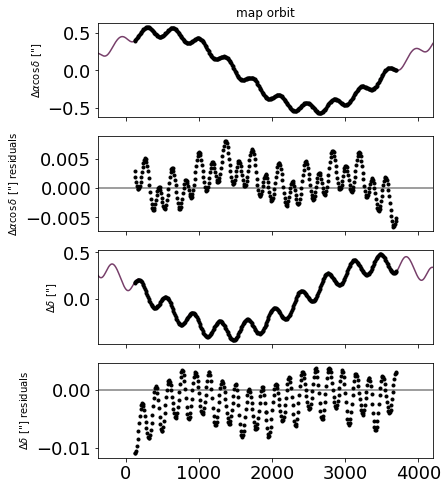

In [6]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r"$\Delta \alpha \cos \delta$ ['']")
ax[1].set_ylabel(r"$\Delta \alpha \cos \delta$ [''] residuals")
ax[2].set_ylabel(r"$\Delta \delta$ ['']")
ax[3].set_ylabel(r"$\Delta \delta$ [''] residuals")


tot_ra_err = np.sqrt(ra_err ** 2 + np.exp(2 * map_soln["log_ra_s"]))
tot_dec_err = np.sqrt(dec_err ** 2 + np.exp(2 * map_soln["log_dec_s"]))

ax[0].errorbar(x_astrometry, ra_data, yerr=tot_ra_err, **ekw)
ax[0].plot(t_fine, map_soln["ra_model_fine"], color="#773f6a")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
    x_astrometry, ra_data - map_soln["ra_model"], yerr=tot_ra_err, **ekw
)


ax[2].plot(t_fine, map_soln["dec_model_fine"], color="#773f6a")
ax[2].errorbar(x_astrometry, dec_data, yerr=tot_dec_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
    x_astrometry, dec_data - map_soln["dec_model"], yerr=tot_dec_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("map orbit")

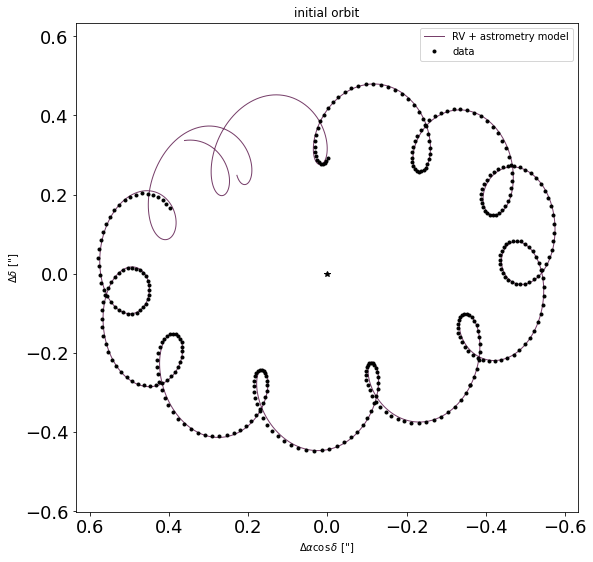

In [7]:
fig, ax = plt.subplots(1, figsize = [9,9])
ax.plot(map_soln["ra_model_fine"], map_soln["dec_model_fine"], color="#773f6a", lw=1, label = "RV + astrometry model")


# plot the data
ax.plot(ra_data, dec_data, ".k", label = "data")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")
ax.legend()
plt.show()

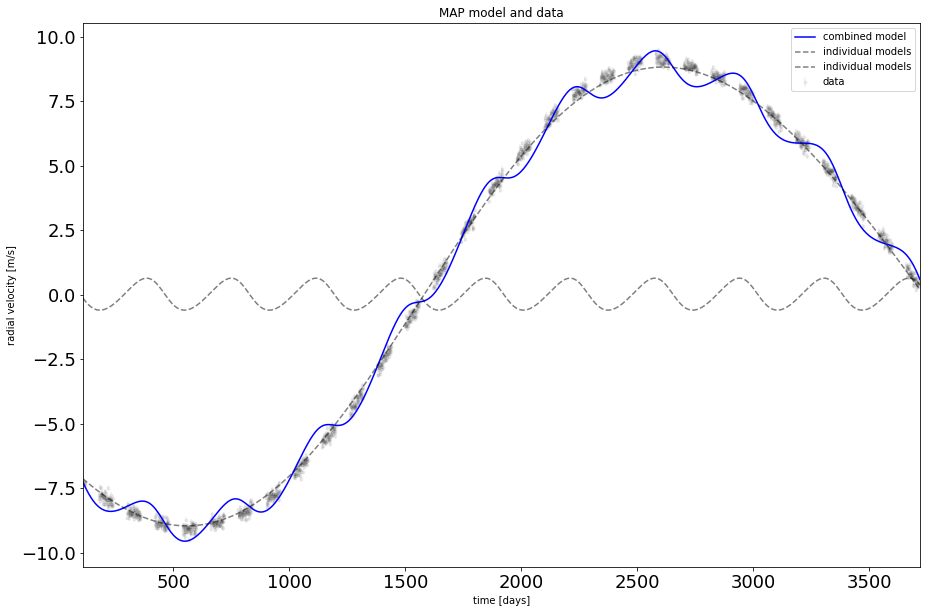

In [8]:
fig, ax = plt.subplots(1, figsize = [15,10])

ax.errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha = 0.05, label='data', zorder=1)
ax.plot(t_rv, map_soln["rv_model_pred"], "b", label="combined model", zorder=2)
ax.plot(t_rv, map_soln["vrad_pred"], "--k", alpha=0.5, label="individual models")


ax.legend(fontsize=10)
ax.set_xlim(t_rv.min(), t_rv.max())
ax.set_xlabel("time [days]")
ax.set_ylabel("radial velocity [m/s]")
ax.set_title("MAP model and data")

plt.show()

In [9]:
print(map_soln['m_planet'])
print(map_soln['incl'])
print(map_soln['Omega'])
print(map_soln['tperi'])

[  9.51168936 311.60165068]
[0.81126371 0.81126371]
[-0.0209196   1.75290328]
[  76.33509054 1434.29307107]


In [10]:
print([m_earth*m_sun, m_jup*m_sun])
print([inclination_earth, inclination_jup])
print([Omega_earth, Omega_jup])
print([Tper_earth, Tper_jup])


[0.9999991719, 317.829736804977]
[0.7853981633974483, 0.808261976598574]
[0.0, 1.7523105690023069]
[115.52083329996094, 1633.721527799964]


KeyError: 'log_rho_s'

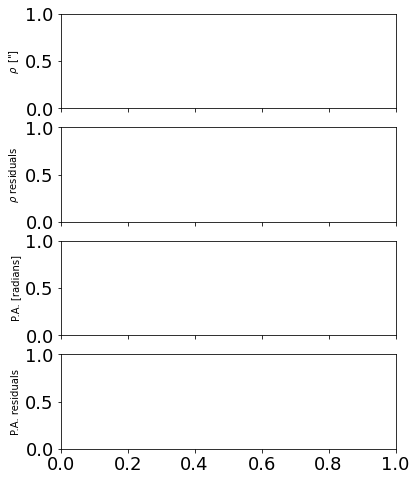

In [6]:


ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"$\rho$ residuals")
ax[2].set_ylabel(r"P.A. [radians]")
ax[3].set_ylabel(r"P.A. residuals")

tot_rho_err = np.sqrt(rho_err ** 2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err ** 2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(x_astrometry, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_model_pred"], color="#773f6a")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
	x_astrometry, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw
)


ax[2].plot(t_fine, map_soln["theta_model_pred"], color="#773f6a")
ax[2].errorbar(x_astrometry, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
	x_astrometry, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("map orbit")

plt.show()



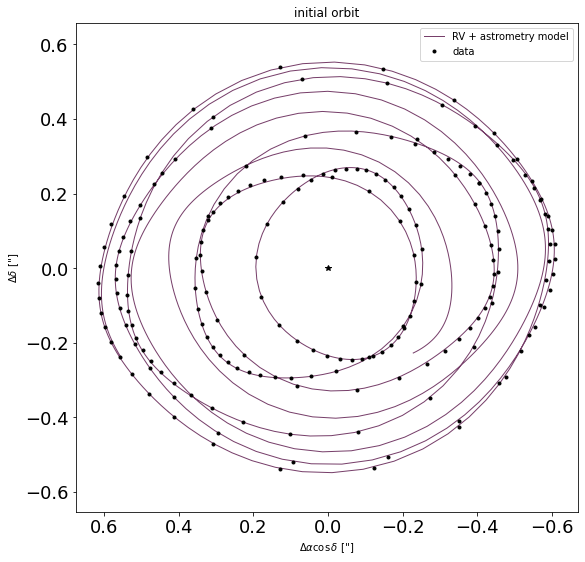

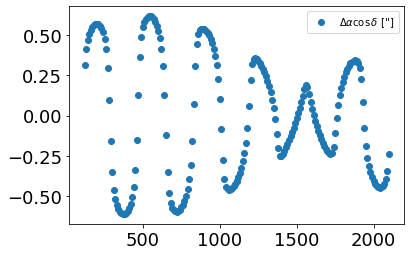

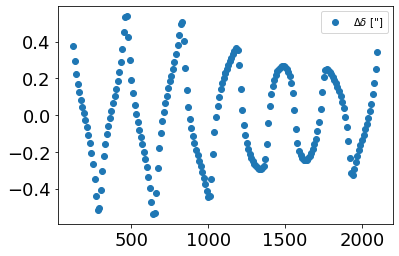

In [260]:


fig, ax = plt.subplots(1, figsize = [9,9])

xs = map_soln["rho_model_pred"] * np.cos(map_soln["theta_model_pred"])  # X is north
ys = map_soln["rho_model_pred"] * np.sin(map_soln["theta_model_pred"])  # Y is east
ax.plot(ys, xs, color="#773f6a", lw=1, label = "RV + astrometry model")


# plot the data
ax.plot(ra_data, dec_data, ".k", label = "data")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")
ax.legend()
plt.show()




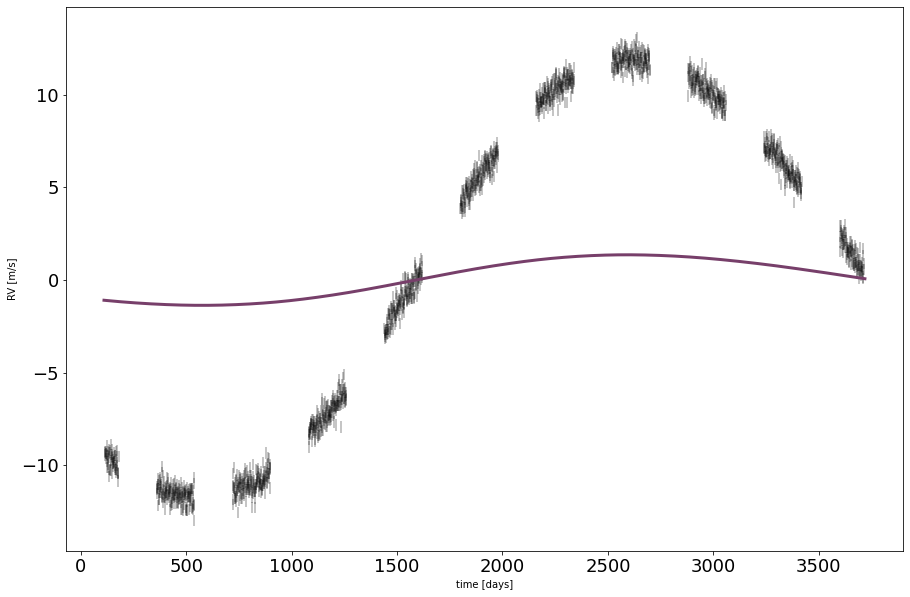

In [257]:
plt.figure(figsize=[15,10])
plt.plot(t_rv, map_soln["rv_model_pred"],color="#773f6a", lw=3)
plt.errorbar(x_rv, y_rv, yerr= y_rv_err, color='k', alpha=0.3, linestyle = '')
plt.xlabel("time [days]")
plt.ylabel("RV [m/s]")
plt.show()



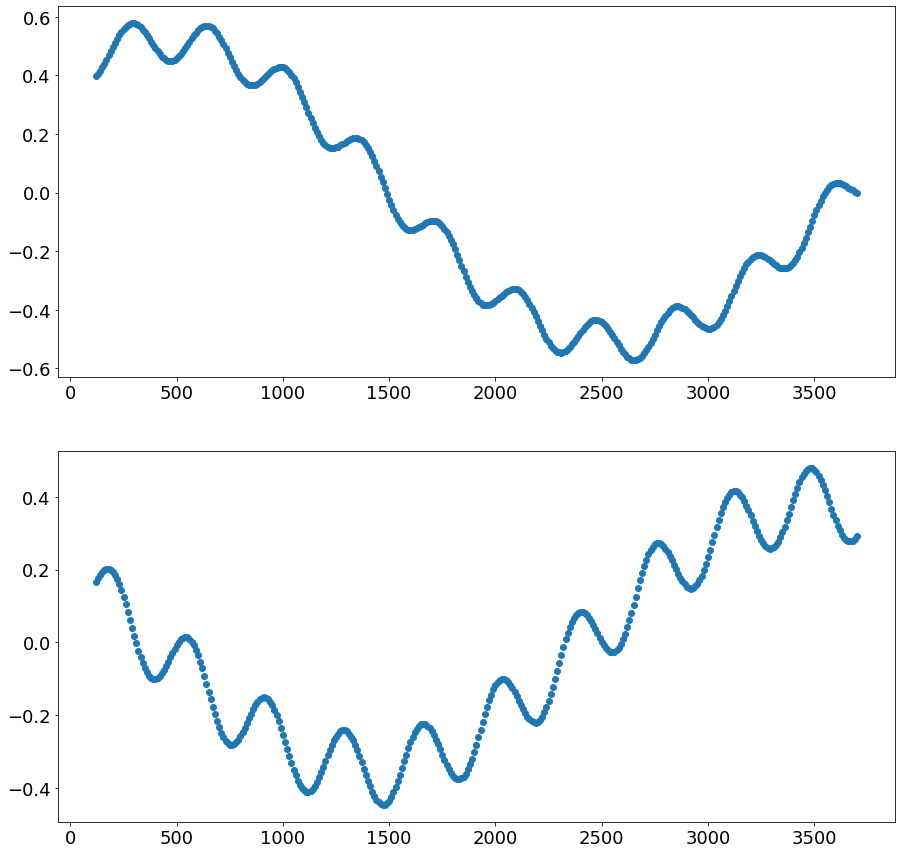

In [144]:
from astropy.coordinates import SkyCoord

# initialize the orbit
orbit = xo.orbits.KeplerianOrbit(
    t_periastron=[Tper_earth, Tper_jup], period=[P_earth, P_jup], ecc=[e_earth, e_jup], 
    omega=[omega_earth, omega_jup], m_planet = [m_earth, m_jup], 
    Omega = [Omega_earth, Omega_jup], incl = [inclination_earth, inclination_jup])



# determine and print the star position at desired times
pos = theano.function([], orbit.get_planet_position(x_astrometry, parallax=parallax))()


#pos = tt.sum(pos, axis=-1)

x,y,z = pos


# calculate rho and theta
rho = tt.squeeze(tt.sqrt(x ** 2 + y ** 2))  # arcsec
theta = tt.squeeze(tt.arctan2(y, x))  # radians between [-pi, pi]


ra = rho * np.sin(theta)
dec = rho * np.cos(theta)

ra_orbit = ra.eval()
dec_orbit = dec.eval()

ra_orbit_sum = tt.sum(ra, axis=-1)
dec_orbit_sum = tt.sum(dec, axis=-1)

ra_orbit_sum = ra_orbit_sum.eval()
dec_orbit_sum = dec_orbit_sum.eval()


fig, ax = plt.subplots(2, 1, figsize = (15,15))


ax[0].plot(x_astrometry, ra_orbit_sum, 'o')

ax[1].plot(x_astrometry, dec_orbit_sum, 'o')

[[2.17990033e-07 4.62195618e-04]
 [2.30292235e-07 4.63856264e-04]
 [2.45284585e-07 4.65487949e-04]
 [2.60853276e-07 4.67089579e-04]
 [2.75185532e-07 4.68660084e-04]
 [2.86882144e-07 4.70198413e-04]
 [2.94962996e-07 4.71703543e-04]
 [2.98839670e-07 4.73174472e-04]
 [2.98286569e-07 4.74610221e-04]
 [2.93420364e-07 4.76009836e-04]
 [2.84689771e-07 4.77372384e-04]
 [2.72874931e-07 4.78696956e-04]
 [2.59092002e-07 4.79982669e-04]
 [2.44788684e-07 4.81228659e-04]
 [2.31694987e-07 4.82434089e-04]
 [2.21664386e-07 4.83598142e-04]
 [2.16341299e-07 4.84720028e-04]
 [2.16697702e-07 4.85798978e-04]
 [2.22678693e-07 4.86834246e-04]
 [2.33227717e-07 4.87825112e-04]
 [2.46670201e-07 4.88770877e-04]
 [2.61170054e-07 4.89670867e-04]
 [2.75039540e-07 4.90524431e-04]
 [2.86879045e-07 4.91330941e-04]
 [2.95615151e-07 4.92089795e-04]
 [3.00499329e-07 4.92800413e-04]
 [3.01100156e-07 4.93462239e-04]
 [2.97302003e-07 4.94074741e-04]
 [2.89314143e-07 4.94637411e-04]
 [2.77691064e-07 4.95149767e-04]
 [2.633624

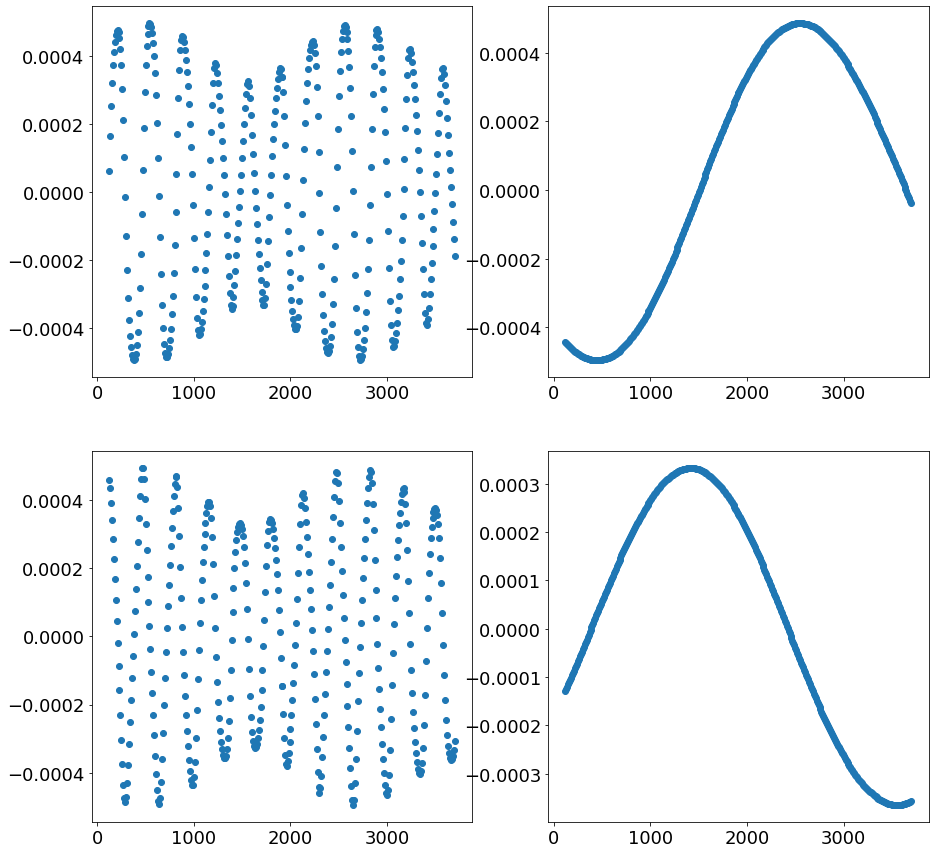

In [166]:
from astropy.coordinates import SkyCoord

# initialize the orbit
orbit = xo.orbits.KeplerianOrbit(
    t_periastron=[Tper_earth, Tper_jup], period=[P_earth, P_jup], ecc=[e_earth, e_jup], 
    omega=[omega_earth, omega_jup], m_planet = [m_earth, m_jup], 
    Omega = [Omega_earth, Omega_jup], incl = [inclination_earth, inclination_jup])



# determine and print the star position at desired times
pos = theano.function([], orbit.get_star_position(x_astrometry, parallax=parallax))()


#pos = tt.sum(pos, axis=-1)

x,y,z = pos


# calculate rho and theta
rho = tt.squeeze(tt.sqrt(x ** 2 + y ** 2))  # arcsec
theta = tt.squeeze(tt.arctan2(y, x))  # radians between [-pi, pi]


ra = rho * np.sin(theta)
dec = rho * np.cos(theta)

ra_single = ra.eval()
dec_single = dec.eval()

ra_orbit_sum = tt.sum(ra, axis=-1)
dec_orbit_sum = tt.sum(dec, axis=-1)

ra_orbit_sum = ra_orbit_sum.eval()
dec_orbit_sum = dec_orbit_sum.eval()


fig, ax = plt.subplots(2, 2, figsize = (15,15))


ax[0][0].plot(x_astrometry, ra_orbit, 'o')
ax[0][1].plot(x_astrometry, ra_orbit_sum, 'o')

ax[1][0].plot(x_astrometry, dec_orbit, 'o')
ax[1][1].plot(x_astrometry, dec_orbit_sum, 'o')

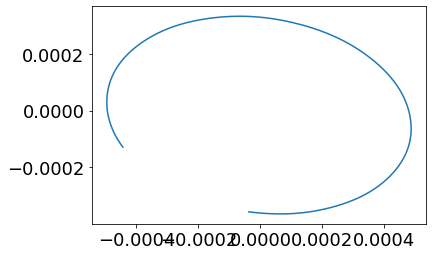

In [138]:
plt.plot(ra, dec)

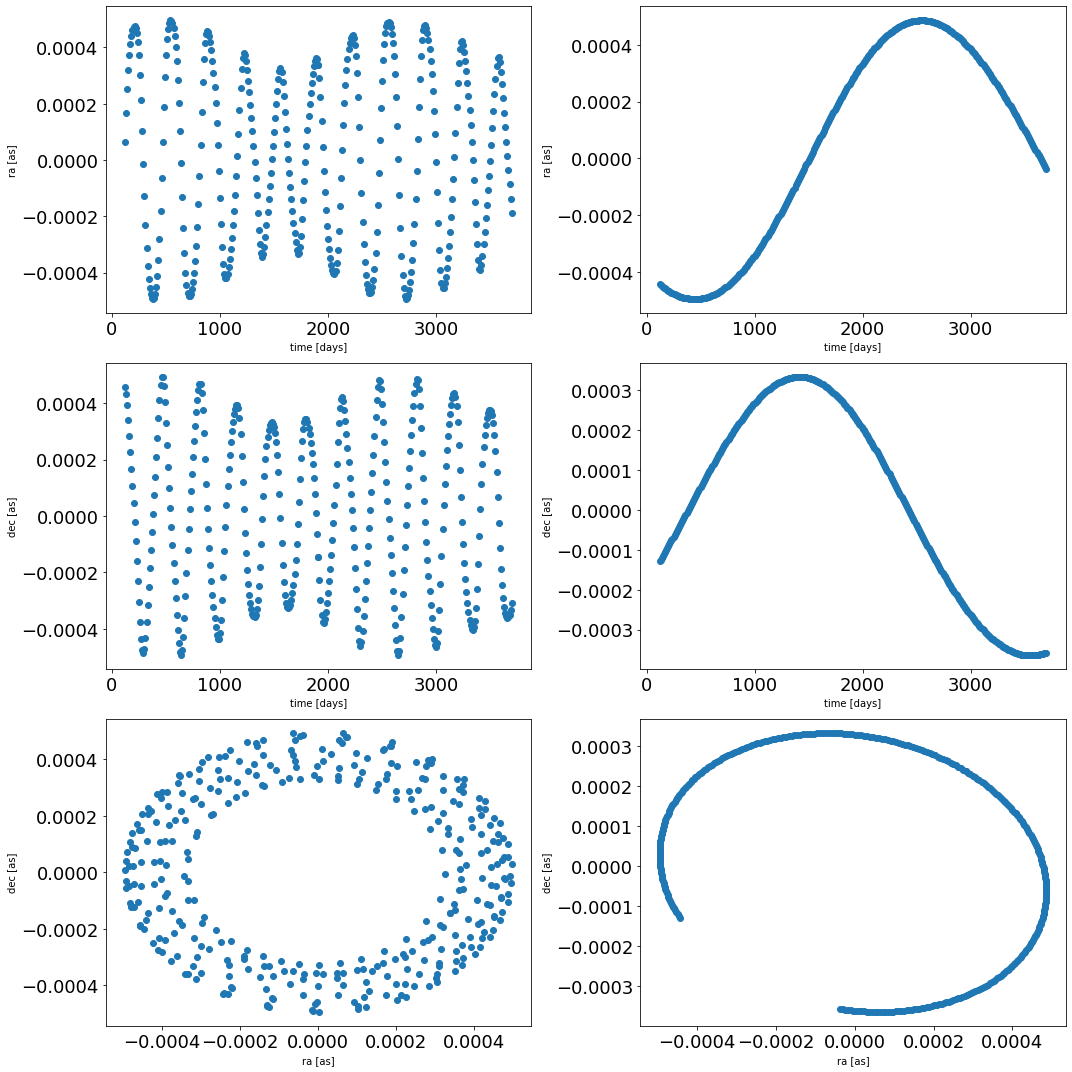

In [162]:
from astropy.coordinates import SkyCoord

# initialize the orbit
orbit = xo.orbits.KeplerianOrbit(
    t_periastron=[Tper_earth, Tper_jup], period=[P_earth, P_jup], ecc=[e_earth, e_jup], 
    omega=[omega_earth, omega_jup], m_planet = [m_earth, m_jup], 
    Omega = [Omega_earth, Omega_jup], incl = [inclination_earth, inclination_jup])



# determine and print the star position at desired times
pos = theano.function([], orbit.get_star_position(x_astrometry, parallax=parallax))()


#pos = tt.sum(pos, axis=-1)

x,y,z = pos


# calculate rho and theta
rho = tt.squeeze(tt.sqrt(x ** 2 + y ** 2))  # arcsec
theta = tt.squeeze(tt.arctan2(y, x))  # radians between [-pi, pi]


rho = tt.sum(rho, axis=-1)
theta = tt.sum(theta, axis=-1)

ra = rho * np.sin(theta)
dec = rho * np.cos(theta)

ra_orbit = ra.eval()
dec_orbit = dec.eval()



fig, ax = plt.subplots(3, 2, figsize = (15,15))


ax[0][0].plot(x_astrometry, ra_orbit, 'o')
ax[0][1].plot(x_astrometry, ra_orbit_sum, 'o')

ax[1][0].plot(x_astrometry, dec_orbit, 'o')
ax[1][1].plot(x_astrometry, dec_orbit_sum, 'o')


ax[2][0].plot(ra_orbit, dec_orbit, 'o')
ax[2][1].plot(ra_orbit_sum, dec_orbit_sum, 'o')

ax[0][0].set_xlabel('time [days]')
ax[0][1].set_xlabel('time [days]')
ax[1][0].set_xlabel('time [days]')
ax[1][1].set_xlabel('time [days]')

ax[0][0].set_ylabel('ra [as]')
ax[0][1].set_ylabel('ra [as]')
ax[1][0].set_ylabel('dec [as]')
ax[1][1].set_ylabel('dec [as]')

ax[2][0].set_xlabel('ra [as]')
ax[2][1].set_xlabel('ra [as]')

ax[2][0].set_ylabel('dec [as]')
ax[2][1].set_ylabel('dec [as]')

fig.tight_layout()

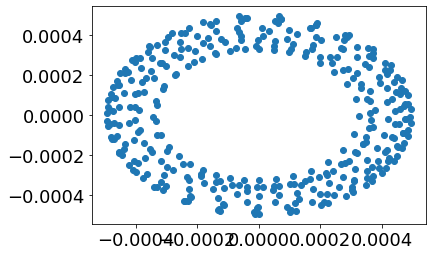

In [152]:
.plot(ra_orbit, dec_orbit, 'o')

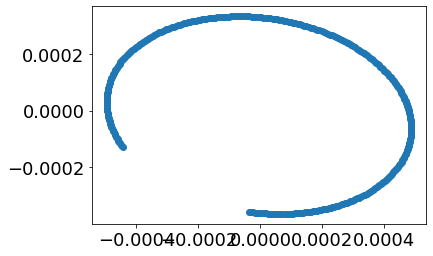

In [154]:
plt.plot(ra_orbit_sum, dec_orbit_sum, 'o')

In [181]:
print(x,y,z)

[ 3.42886449e-04  5.57052859e-02  1.09589451e-01  1.59887830e-01
  2.07669248e-01  2.52163213e-01  2.90130015e-01  3.20898141e-01
  3.45817449e-01  3.63193475e-01 -3.20124986e-01 -3.51123531e-01
 -3.75806180e-01 -3.91761102e-01 -4.00056772e-01 -4.02273996e-01
 -3.96728049e-01 -3.82464158e-01 -3.61836305e-01 -3.35800957e-01] [-0.96544281 -1.01625249 -1.04638225 -1.05550394 -1.04323633 -1.00861981
 -0.9519323  -0.87471985 -0.77806636 -0.66313014  0.93869401  0.86488918
  0.77352945  0.66701428  0.54823456  0.41910288  0.28164856  0.13915293
 -0.00545822 -0.15026144] [-0.00238212 -0.00176768 -0.00112426 -0.00045565  0.00022785  0.00090229
  0.00155302  0.00217496  0.00275055  0.00325702 -0.00200443 -0.002608
 -0.00315416 -0.00363745 -0.00405751 -0.00440097 -0.00465595 -0.00482702
 -0.0049151  -0.00490955] solRad2


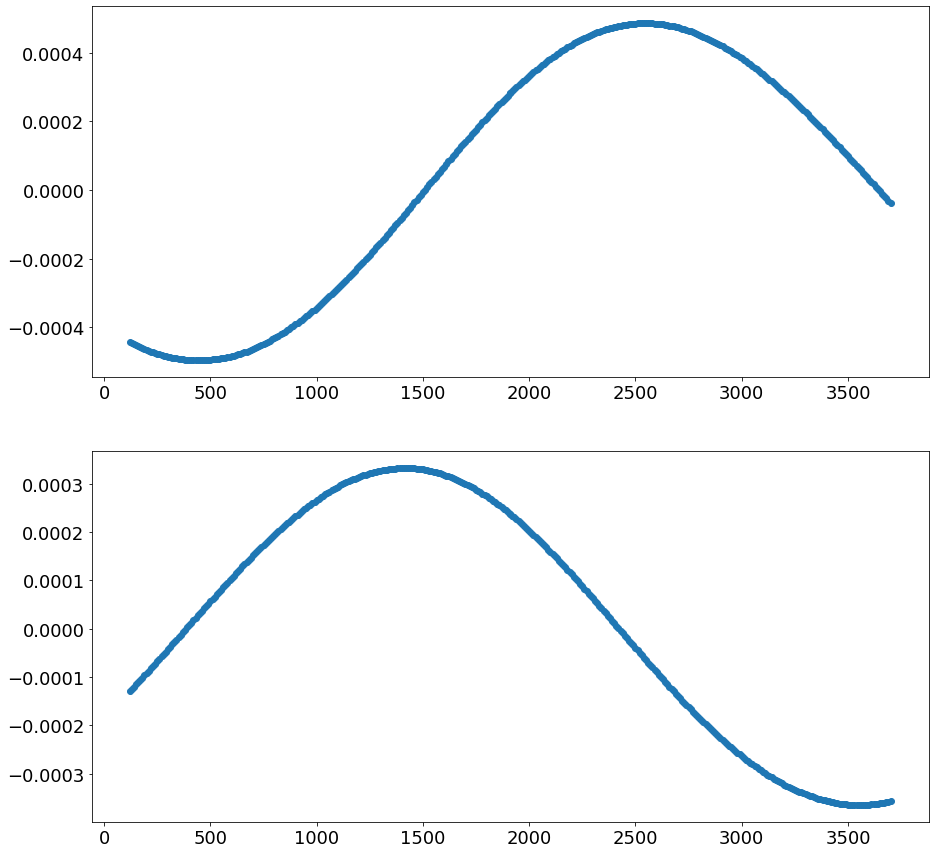

In [170]:
def get_star_relative_angles(t, parallax):
    
    # determine and print the star position at desired times
    pos = theano.function([], orbit.get_star_position(t, parallax))()


    #pos = tt.sum(pos, axis=-1)

    x,y,z = pos


    # calculate rho and theta
    rho = tt.squeeze(tt.sqrt(x ** 2 + y ** 2))  # arcsec
    theta = tt.squeeze(tt.arctan2(y, x))  # radians between [-pi, pi]
    
    rho, theta = rho.eval(), theta.eval()
    
    return rho, theta


rho, theta = get_star_relative_angles(x_astrometry, parallax)


ra = rho * np.sin(theta)
dec = rho * np.cos(theta)

#ra_single = ra.eval()
#dec_single = dec.eval()

ra_orbit_sum = tt.sum(ra, axis=-1)
dec_orbit_sum = tt.sum(dec, axis=-1)

ra_orbit_sum = ra_orbit_sum.eval()
dec_orbit_sum = dec_orbit_sum.eval()


fig, ax = plt.subplots(2, 1, figsize = (15,15))


ax[0].plot(x_astrometry, ra_orbit_sum, 'o')

ax[1].plot(x_astrometry, dec_orbit_sum, 'o')